In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import matplotlib.pyplot as plt
import cartopy

import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils
import cmocean
import metpy.calc as mpcalc

#### Define case and path

#### Get grid

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

#### Define variable list

In [3]:
variables = ['x_graze_mesozoo_zint','POC_FLUX_100m']
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = ['dz','KMT','time_bound'] + variables + list(coords.values())

In [4]:
%%time

ds = xr.Dataset()

for v in variables:  
    print(v)
    files = f'{path}/{case}.pop.h.{v}.195801-202112.nc'

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

x_graze_mesozoo_zint
POC_FLUX_100m
CPU times: user 511 ms, sys: 46.6 ms, total: 557 ms
Wall time: 957 ms


In [5]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [6]:
ds.time[451]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1995, 8, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1995-08-16 12:00:00

### spin up dask

In [7]:
# def get_ClusterClient():
#     import dask
#     from dask_jobqueue import PBSCluster
#     from dask.distributed import Client
#     cluster = PBSCluster(
#         cores=1,
#         memory='50GB',
#         processes=1,
#         queue='casper',
#         resource_spec='select=1:ncpus=1:mem=50GB',
#         project='NCGD0011',
#         walltime='03:00:00',
#         interface='ext',)

#     dask.config.set({
#         'distributed.dashboard.link':
#         'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
#     })
#     client = Client(cluster)
#     return cluster, client

In [8]:
# cluster, client = get_ClusterClient()
# cluster.scale(8)
# client

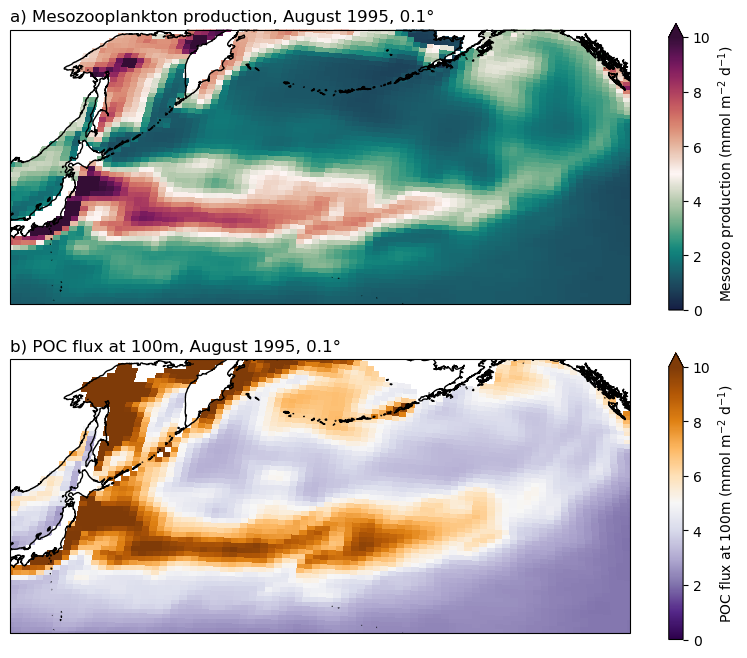

In [9]:
fig = plt.figure(figsize=(10,8))

ts=451

############### 
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('a) Mesozooplankton production, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('b) POC flux at 100m, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

# fig.subplots_adjust(right=0.82,wspace=0.05)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)')

#fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_Npac.png', bbox_inches='tight', dpi=300, format='png');

### Get fish!

In [10]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'

path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/feisty/'

file = f'{path}/FEISTY_monthly_002branch.nc'
        
ds_fish = xr.open_dataset(file)

In [11]:
ds_fish.time[451]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1995, 8, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1995-08-31 00:00:00

In [12]:
ts=451

In [13]:
fish_prod_Aug = ds_fish.production.sum(dim='fish').isel(time=ts)

In [14]:
fish_biomass_Aug = ds_fish.biomass.sum(dim='group').isel(time=ts) - ds_fish.biomass.sel(group='benthic_prey').isel(time=ts)

In [15]:
fish_cmap=cmocean.cm.dense

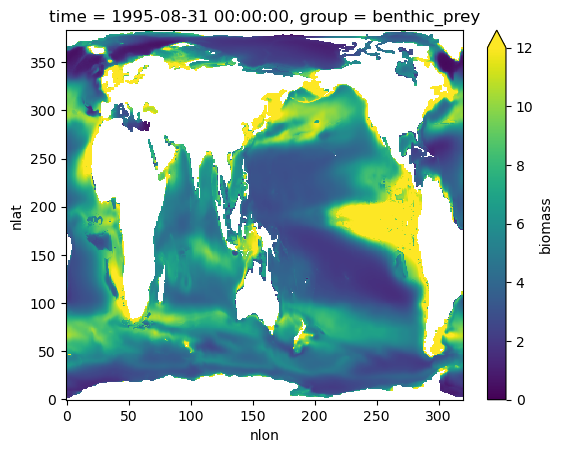

In [16]:
fish_biomass_Aug.plot(vmin=0,vmax=12)

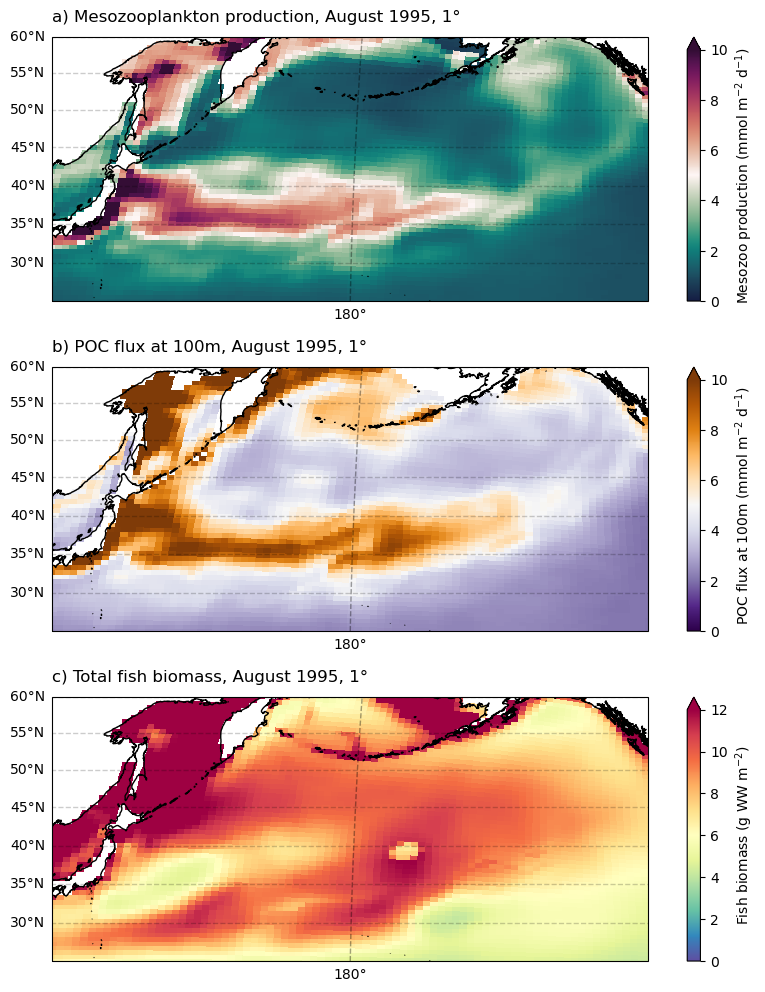

In [17]:
fig = plt.figure(figsize=(10,12))

ts=451

############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('a) Mesozooplankton production, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('b) POC flux at 100m, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)')


############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('c) Total fish biomass, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fish_biomass_Aug)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Spectral_r', #fish_cmap,
                   vmin=0,vmax=12
                  )
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.25)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='Fish biomass (g WW m$^{-2}$)') #d$^{-1}$)')

fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_fish_Npac_x1.png', bbox_inches='tight', dpi=300, format='png');

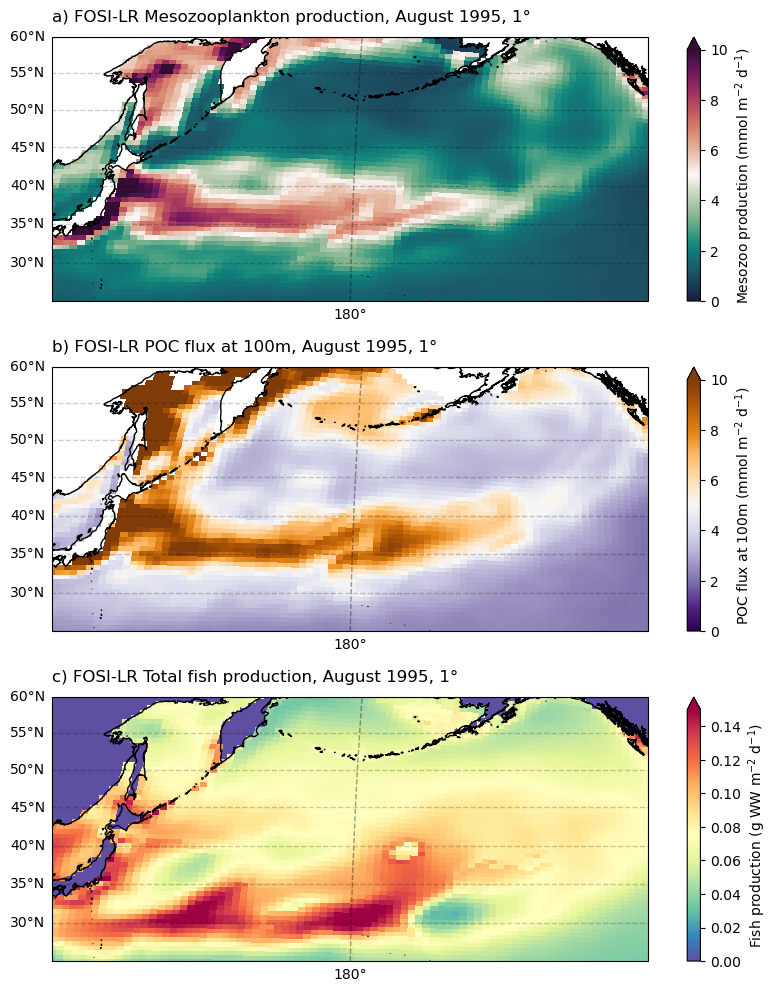

In [18]:
fig = plt.figure(figsize=(10,12))

ts=451

############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('a) FOSI-LR Mesozooplankton production, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('b) FOSI-LR POC flux at 100m, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)')


############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('c) FOSI-LR Total fish production, August 1995, 1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fish_prod_Aug)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Spectral_r', #fish_cmap,
                   vmin=0, vmax=0.15)

ax.coastlines('10m', linewidth=1)

fig.subplots_adjust(hspace=0.25)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='Fish production (g WW m$^{-2}$ d$^{-1}$)')

fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_fishprod_Npac_x1.png', bbox_inches='tight', dpi=300, format='png');

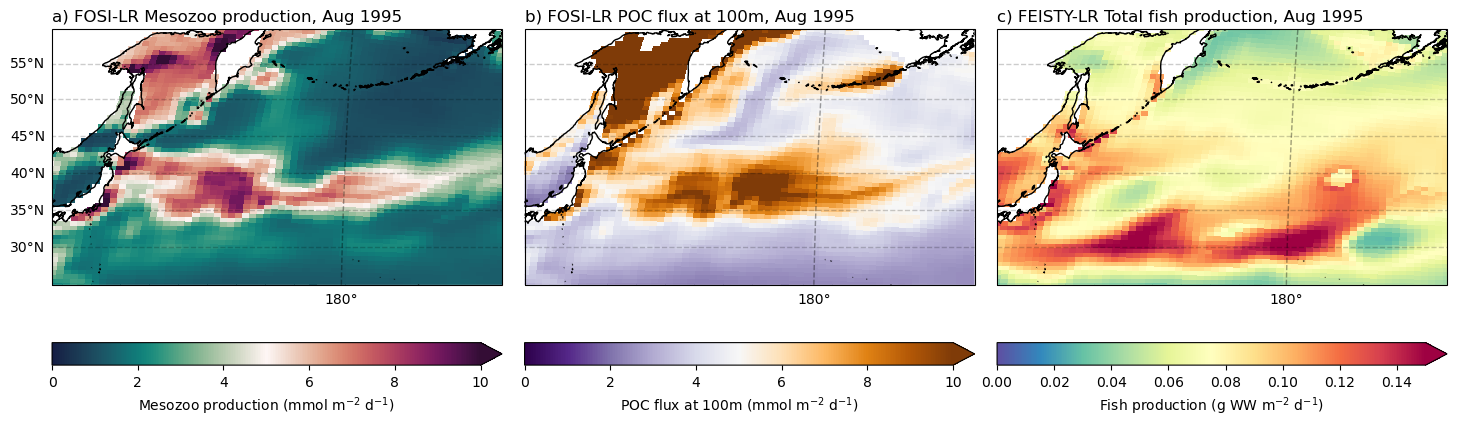

In [20]:
fig = plt.figure(figsize=(18,5))

ts=7

############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -155, 25, 59.9], ccrs.PlateCarree())

ax.set_title('a) FOSI-LR Mesozoo production, Aug 1995', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)', orientation='horizontal')

############### 
ax = fig.add_subplot(1,3,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -155, 25, 59.9], ccrs.PlateCarree())

ax.set_title('b) FOSI-LR POC flux at 100m, Aug 1995', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlabels_bottom = False

cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)', orientation='horizontal')


############### 
ax = fig.add_subplot(1,3,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -155, 25, 59.9], ccrs.PlateCarree())

ax.set_title('c) FEISTY-LR Total fish production, Aug 1995', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fish_prod_Aug.where(ds_grid.REGION_MASK>0))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Spectral_r', #fish_cmap,
                   vmin=0,vmax=0.15
                  )
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(wspace=0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_left = False
gl.xlabels_top = False
gl.ylabels_right = True
cbar1 = fig.colorbar(pc,extend='max',label='Fish production (g WW m$^{-2}$ d$^{-1}$)', orientation='horizontal')

fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_fishprod_Npac_x1.png', bbox_inches='tight', dpi=300, format='png');